# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2)

In [2]:
%matplotlib inline

In [85]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

np.random.seed(1337)

In [86]:
# Load pickled data
import pickle

# fill this in based on where you saved the training and testing data
training_file = 'data/train.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [87]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((39209, 32, 32, 3), (39209,), (12630, 32, 32, 3), (12630,))

In [88]:
### To start off let's do a basic data summary.

# number of training examples
n_train = X_train.shape[0]

# number of testing examples
n_test = X_test.shape[0]

# what's the shape of an image?
image_shape = X_train.shape[1:]

# how many classes are in the dataset
n_classes = np.unique(np.hstack([y_train, y_test])).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

In [89]:
# load text description of sign labels

def load_label_desc(label_file):
    lines = open(label_file).readlines()[1:]
    lines = [line.strip().split(",") for line in lines]
    label_descs = dict([ (int(classid), desc) for classid, desc in lines])
    return label_descs

label_descriptions = load_label_desc("signnames.csv")

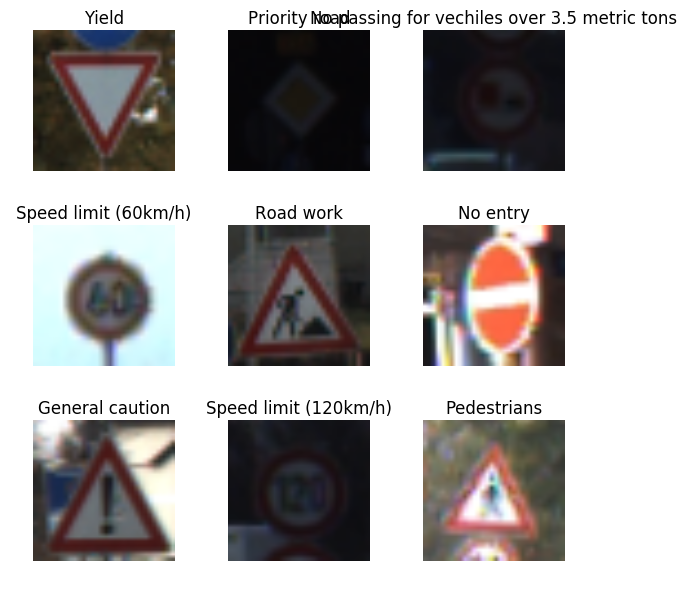

In [93]:
# draw random samples from training data

n_samples = 9
isample = np.random.randint(0, n_train, n_samples)
sample_imgs = X_train[isample]
sample_labels = list(map(label_descriptions.get, y_train[isample]))

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(2*3, 2*3))
axes = axes.ravel()
fig.tight_layout()

for ax, img, label in zip(axes, sample_imgs, sample_labels):
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

*** Observation 1: it looks like the lighting condition in images are very different! Would it help to normalize the illumination of images?***

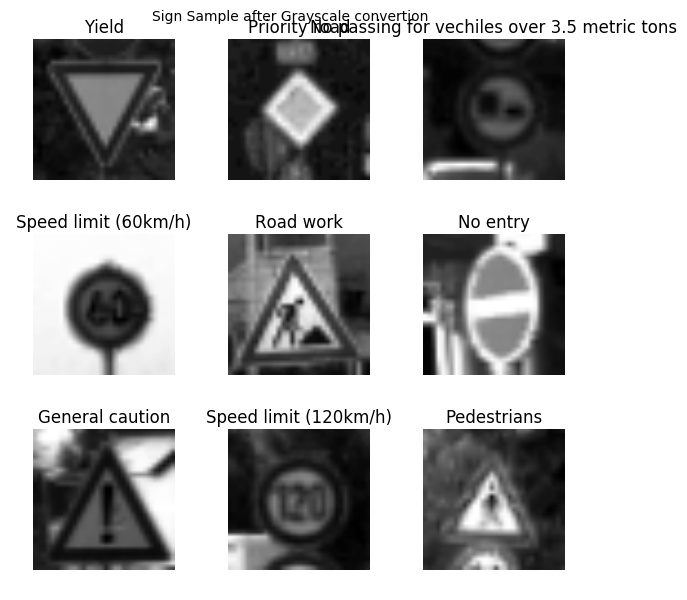

In [94]:
# draw random samples from training data, after convertion to grayscale
# gray scale looks better! - but are we throwing away too much infor on color?

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(2*3, 2*3))
axes = axes.ravel()
fig.suptitle("Sign Sample after Grayscale convertion", verticalalignment='bottom')
fig.tight_layout()

for ax, img, label in zip(axes, sample_imgs, sample_labels):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap=plt.cm.gray)
    ax.set_title(label)
    ax.axis('off')

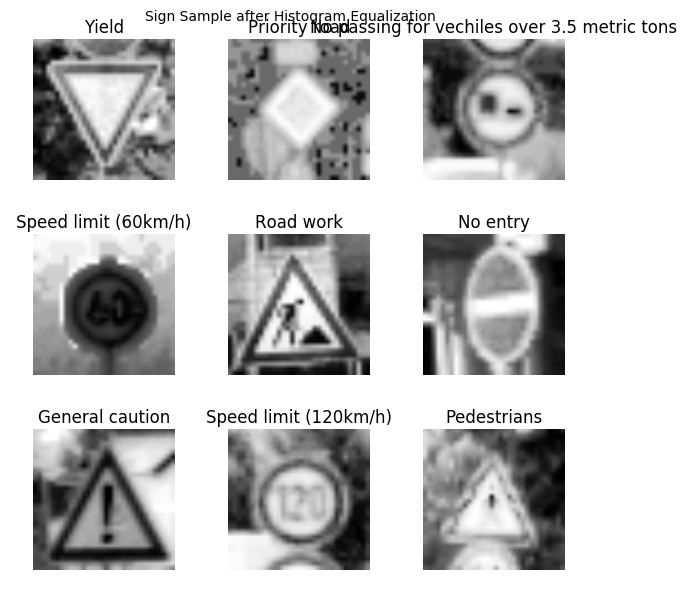

In [95]:
# However, goting further with a naive illumination equalization doesn't look to help too much

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(2*3, 2*3))
axes = axes.ravel()
fig.suptitle("Sign Sample after Histogram Equalization", verticalalignment='bottom')
fig.tight_layout()


for ax, img, label in zip(axes, sample_imgs, sample_labels):
    ax.imshow(cv2.equalizeHist(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)), cmap=plt.cm.gray)
    ax.set_title(label)
    ax.axis('off')

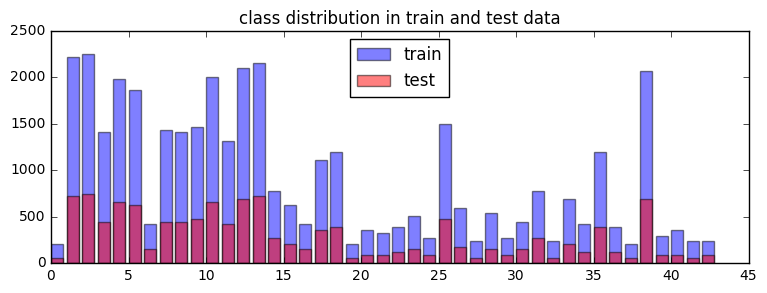

In [122]:
# now look at the distributions of classes in train and test
# 1. are the distributions skewed?
# 2. are the distributions in train and test similiar?

train_classes = np.bincount(y_train)
test_classes = np.bincount(y_test)
assert train_classes.shape[0] == test_classes.shape[0], "train and test data don't have same number of clases"
plt.figure(figsize=(9, 3))
plt.bar(range(n_classes), train_classes, label="train", color="b", alpha=0.5)
plt.bar(range(n_classes), test_classes, label="test", color="r", alpha=0.5)
plt.legend(loc="best")
plt.title("class distribution in train and test data")

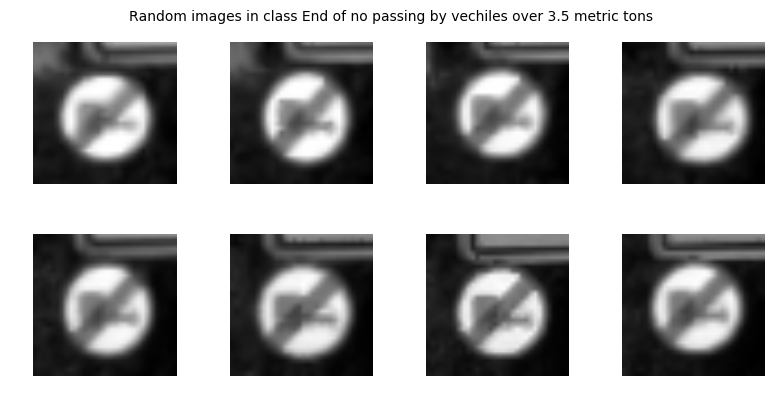

In [216]:
# How similiar are the images within one class
random_class = np.random.randint(0, n_classes)
random_imgs = X_train[(y_train==random_class)][:8]

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(2*4, 2*2))
axes = axes.ravel()
fig.suptitle("Random images in class %s" % label_descriptions[random_class], verticalalignment='bottom')
fig.tight_layout()


for ax, img in zip(axes, random_imgs):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), cmap = plt.cm.gray)
    ax.axis('off')

### Conclusion on Data Exploration
- It is good for many dark images to convert them to grayscale, even though we might have the risk of discarding color information that is useful for classification. But overally convertion to grayscale looks better, we need to test it out in modelling.
- The distributions of sign classes in train ad test are relatively similiar. The sign distributions are skewed - majority of them are within about 15 classes. This is similiar to other image dataset such as CIFAR, ImageNet. I don't see any big issue for now.
- As expected, the images within the same class are very similiar - the signs are essentially 2D, the only variations could be just illuminations, translations and backgrounds. This makes me wonder whether a nearest-neighbor classifier based on the "mean" of images is already a good baseline model.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Before going any further, I want to test with a cheap baseline first
- Use "mean" image as representative within a class
- Use nearest neighbor as classifier
- Result is 29.9% for training and 25.5% for testing, better than random guess: 1/43 = 2.3% :)
- Based on the inspection of baseline, I found the following "trouble-maker" signs:
    - Different cruves, e.g., "Dangerous curve to the right" misclassified vs "Dangerous curve to the left" vs "Double curve"
    - Different speed limits
    - Different crossing, e.g., "Bicycle crossing" vs "Wild Animial Crossing"
    - etc.
- That's what I expected because misclassified images look similiar! ***It looks like we are gonna have some fun!***

In [219]:
# average image based baseline model
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.preprocessing import MinMaxScaler

class NNClassifier(object):
    def __init__(self):
        self.classes = None
        self.vecs = None
        
    def fit(self, train_x, train_y):
        representative_vectors = []
        for cls in np.unique(train_y):
            vec = train_x[train_y == cls].mean(axis = 0)
            representative_vectors.append( (cls,vec) )
        classes, vecs = zip(*representative_vectors)
        self.classes = np.array(classes)
        self.vecs = np.array(vecs)
        return self
    
    def predict(self, test_x):
        if self.vecs is None:
            raise ValueError("Fit the model first")
        scores = cosine_distances(test_x, self.vecs)
        return self.classes[np.argmin(scores, axis = 1)]
    
    def score(self, test_x, test_y):
        yhat = self.predict(test_x)
        return np.mean(yhat == test_y)
    
    def classwise_score(self, test_x, test_y):
        import pandas as pd
        yhat = self.predict(test_x)
        result = []
        for cls in np.unique(test_y):
            i = (test_y == cls)
            result.append({
                    'class': label_descriptions[cls],
                    'accuracy': np.mean(yhat[i]==cls),
                    'top classfied as': label_descriptions[np.argmax(np.bincount(yhat[i]))],
                    'size': np.sum(i)
                })
        return pd.DataFrame(result).sort_values("accuracy")
    
# normalize data first
def to_grayscale(x):
    nx = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).ravel() for img in x])
    return nx


scaler = MinMaxScaler()
normalized_x_train = scaler.fit_transform(to_grayscale(X_train))
normalized_x_test  = scaler.transform(to_grayscale(X_test))

# test with baseline
baseline_model = NNClassifier().fit(normalized_x_train, y_train)
train_accuracy = baseline_model.score(normalized_x_train, y_train)
test_accuracy = baseline_model.score(normalized_x_test, y_test)
print("train accuracy of baseline:", train_accuracy)
print("test accuracy of baseline:", test_accuracy)

/root/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


train accuracy of baseline: 0.299370042592
test accuracy of baseline: 0.255186064925


*show what are the signs that can give us troubles*

In [221]:
from IPython.display import display
train_result = baseline_model.classwise_score(normalized_x_train, y_train)
test_result = baseline_model.classwise_score(normalized_x_test, y_test)
display(train_result.head(10))
display(test_result.head(10))

,accuracy,class,size,top classfied as
20,0.019444,Dangerous curve to the right,360,Dangerous curve to the left
8,0.033333,Speed limit (120km/h),1410,Speed limit (70km/h)
7,0.042361,Speed limit (100km/h),1440,Speed limit (70km/h)
5,0.048925,Speed limit (80km/h),1860,Speed limit (60km/h)
29,0.111111,Bicycles crossing,270,Wild animals crossing
42,0.116667,End of no passing by vechiles over 3.5 metric ...,240,End of no passing
23,0.121569,Slippery road,510,Dangerous curve to the left
1,0.121622,Speed limit (30km/h),2220,Speed limit (70km/h)
15,0.147619,No vechiles,630,Speed limit (60km/h)
21,0.151515,Double curve,330,Dangerous curve to the left


,accuracy,class,size,top classfied as
20,0.000000,Dangerous curve to the right,90,Dangerous curve to the left
40,0.022222,Roundabout mandatory,90,Speed limit (60km/h)
5,0.023810,Speed limit (80km/h),630,Speed limit (70km/h)
22,0.025000,Bumpy road,120,Traffic signals
23,0.046667,Slippery road,150,Dangerous curve to the left
7,0.046667,Speed limit (100km/h),450,Speed limit (60km/h)
8,0.051111,Speed limit (120km/h),450,Speed limit (60km/h)
18,0.066667,General caution,390,Wild animals crossing
28,0.080000,Children crossing,150,Dangerous curve to the right
0,0.083333,Speed limit (20km/h),60,Speed limit (70km/h)


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

1. Following the "30 samples" rule in the class, I separate 10K of the original training data as valiation set, and use the whole original test data for final testing. So ~30K original images will be used for training. Given the similarity of the images (see the exploration above), it should be enough for big sign classes. I will use image aurgmentation (random rotation and shift) to first boost performances for minor classes.

2. Here I am following the paradigm of converting training data into a data generator, because
    - it is easier to support out-of-core training when the dataset becomes larger for memory
    - it is easier to plug preprocessing/augmentation code because all code is in one place
    - it can be potentially faster, if data generating is running on CPU whereas training models on GPU.

3. In detail, the preprocessing steps I am currently using are,
    - gray scale
    - normalization of pixel ranges to [0, 1]



**some helper functions**

In [321]:
def plot_images(images, nrows, titles = None, plot_size=2, is_gray=False):
    ncols = int(np.ceil(images.shape[0] / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(plot_size*ncols, plot_size*nrows))
    fig.tight_layout()
    axes = axes.ravel()
    cmap = plt.cm.gray if is_gray else None
    titles = titles or [None] * images.shape[0]
    for img, ax, title in zip(images, axes, titles):
        ax.imshow(img, cmap=cmap)
        ax.set_title(title)
        
import functools

def compose(functions):
    def compose2(f, g):
        return lambda x: f(g(x))
    return functools.reduce(compose2, functions[::-1])

**train, valid, test data split**

In [283]:
# train, valid, test data split
from sklearn.cross_validation import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size = 10000)
test_x, test_y = X_test, y_test
print(train_x.shape, valid_x.shape, train_y.shape, valid_y.shape, test_x.shape, test_y.shape)

(29209, 32, 32, 3) (10000, 32, 32, 3) (29209,) (10000,) (12630, 32, 32, 3) (12630,)


** data generator with preprocessing pipeline and image augmentation **

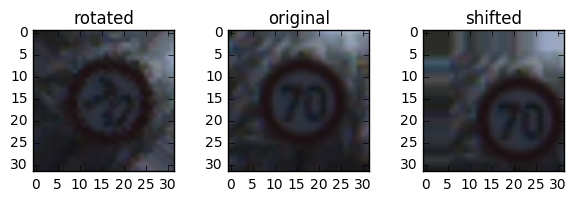

In [296]:
# image dataset augmentation
# borrow some code from Keras library https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py
import scipy.ndimage as ndi

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x, transform_matrix, channel_index=2, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_index, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                      final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x

def random_rotation(img, degree=45):
    theta = np.pi / 180 * np.random.uniform(-degree, degree)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    h, w = img.shape[0], img.shape[1]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(img, transform_matrix, channel_index=2)
    return x

def random_shift(img, shiftw=0.15, shifth=0.15):
    h, w = img.shape[0], img.shape[1]
    tx = np.random.uniform(-shifth, shifth) * h
    ty = np.random.uniform(-shiftw, shiftw) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(img, transform_matrix, 2)
    return x

################# test image augmentations ##################
i = np.random.randint(0, train_x.shape[0])
images = {
    "original": train_x[i]
    , "rotated": random_rotation(train_x[i], 45)
    , "shifted": random_shift(train_x[i], 0.2, 0.2)
}
plot_images(np.array(list(images.values())), nrows=1, titles=images.keys())

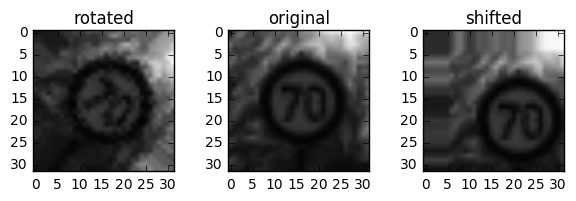

In [323]:
# preprocessing

def preprocess_grayscale(images):
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])

def preprocess_normalize(images):
    return images / 255.

################# test image preprocessing ##################
p = compose([preprocess_grayscale, preprocess_normalize])

plot_images(p(list(images.values())), nrows=1, titles=images.keys(), is_gray=True)

In [ ]:
## data generator


def batch_geneator(xs, ys, batch_size=64, augmentation_methods=None, preprocess_steps=None):
    """Generate input, output batches based on data - it will loop forever
    
    - xs, ys: inputs (images) and outputs (labels)
    - batch_size: # of instances in a generated batch
    - augmentation_methods: list of tuple (method, factor), where method is used to generate new images 
      and factor is # of augmented images generated for each original. 
      e.g., [(random_rotation, 5), (random_shift, 10)]
    - preprocess_steps: list of methods to be applied to batch of images
    """
    assert xs.shape[0] == ys.shape[0], "inputs and outputs don't have matched size"
    n_samples = xs.shape[0]
    process = compose(preprocess_steps)
    
    x_pool, y_pool = [], []
    
    i = 0
    while True:
        i = i % n_samples
        img, label = xs[i], ys[i]
        x_pool.append(img)
        y_pool.append(label)
        for fn, num in augmentation_methods:
            for _ in range(num):
                x_pool.append(fn(img))
                y_pool.append(label)
        if len(x_pool) >= batch_size:
            x_batch = np.array
        i += 1

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [5]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [3]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [4]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.